In [10]:
import numpy as np
import pandas as pd
import string
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from gensim.parsing.preprocessing import remove_stopwords
from nltk.tokenize.treebank import TreebankWordDetokenizer

In [11]:
tw_df = pd.read_csv('../data/2-tweets_en_nodup.csv',lineterminator='\n')
#taking relevant columns only
tw_df = tw_df[['timestamp','text']]
tw_df.head()

,timestamp,text
0,2016-01-01 00:00:04+00:00,Current price: 431.05$ $BTCUSD $btc #bitcoin 2...
1,2016-01-01 00:00:05+00:00,Current price: 396.05€ $BTCEUR $btc #bitcoin 2...
2,2016-01-01 00:00:05+00:00,Current price: 291.77£ $BTCGBP $btc #bitcoin 2...
3,2016-01-01 00:00:53+00:00,#RDD / #BTC on the exchanges:\nCryptsy: 0.0000...
4,2016-01-01 00:02:32+00:00,#RDD / #BTC on the exchanges: Cryptsy: 0.00000...


In [12]:
#punctuation inclusing the hashtags
tw_df['text'] = tw_df['text'].apply(lambda x: x.translate(str.maketrans('','',string.punctuation)))
#removing the links
tw_df['text'] = tw_df['text'].apply(lambda x: re.sub("(http[\w]+)","",x))
#tabs and new line
tw_df['text'] = tw_df['text'].apply(lambda x: re.sub("(\r\n|\n|\r|\t)"," ",x))
#remove all digits
tw_df['text'] = tw_df['text'].apply(lambda x: re.sub(r"\b\d+\b"," ",x))
#stopwords
tw_df['text'] = tw_df['text'].apply(lambda x: remove_stopwords(x))
tw_df.head()

,timestamp,text
0,2016-01-01 00:00:04+00:00,Current price BTCUSD btc bitcoin EST
1,2016-01-01 00:00:05+00:00,Current price € BTCEUR btc bitcoin CET
2,2016-01-01 00:00:05+00:00,Current price £ BTCGBP btc bitcoin GMT
3,2016-01-01 00:00:53+00:00,RDD BTC exchanges Cryptsy Bittrex Average 17E5...
4,2016-01-01 00:02:32+00:00,RDD BTC exchanges Cryptsy Bittrex Average 17E5...


In [13]:
#lemmatizing the word
lemmatizer = nltk.stem.WordNetLemmatizer()
tokenizer = TweetTokenizer()
tw_df['token'] = tw_df['text'].apply(lambda x:[(lemmatizer.lemmatize(w)) for w in tokenizer.tokenize((x))])

#removing stopwords
from sklearn.feature_extraction import text
stop = text.ENGLISH_STOP_WORDS
tw_df['token'] = tw_df['token'].apply(lambda x: [item for item in x if item not in stop])
#getting words more than 4 wrods
tw_df = tw_df[tw_df['token'].map(len) > 4]

In [14]:
tw_df.head()

,timestamp,text,token
0,2016-01-01 00:00:04+00:00,Current price BTCUSD btc bitcoin EST,"[Current, price, BTCUSD, btc, bitcoin, EST]"
1,2016-01-01 00:00:05+00:00,Current price € BTCEUR btc bitcoin CET,"[Current, price, €, BTCEUR, btc, bitcoin, CET]"
2,2016-01-01 00:00:05+00:00,Current price £ BTCGBP btc bitcoin GMT,"[Current, price, £, BTCGBP, btc, bitcoin, GMT]"
3,2016-01-01 00:00:53+00:00,RDD BTC exchanges Cryptsy Bittrex Average 17E5...,"[RDD, BTC, exchange, Cryptsy, Bittrex, Average..."
4,2016-01-01 00:02:32+00:00,RDD BTC exchanges Cryptsy Bittrex Average 17E5...,"[RDD, BTC, exchange, Cryptsy, Bittrex, Average..."


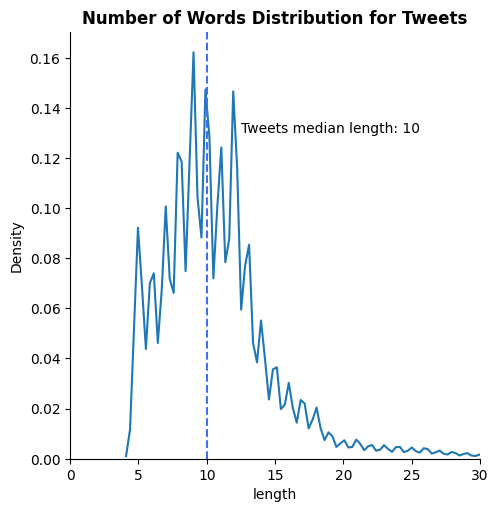

In [17]:
#post length distribution
import seaborn as sns
import matplotlib.pyplot as plt
tw_df['length'] = tw_df['token'].apply(lambda x: len(x))
sns.displot(data=tw_df,x='length',kind='kde',palette=['#ECC445'])
plt.xlim(0,30)
plt.axvline(x=tw_df['length'].median(),color='#456DEC',linestyle='--')
plt.annotate(f'Tweets median length: 10',xy=(12.5,0.13),fontsize=10)
plt.title('Number of Words Distribution for Tweets',fontweight = 'bold');


In [16]:
tw_df['length'].median()

10.0

In [18]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
cv = CountVectorizer()
text_cv = cv.fit_transform(tw_df['text'].iloc[:50])
col_df = pd.DataFrame(text_cv.todense(),columns=cv.get_feature_names_out())
col_df.head()

,1727mxn,17e5,24h,ago,alerts,arb,average,b373,b374,b390,...,usd,usd100,usd31392btc,usd43008,utc,volume,winkdex,worth,year,yielding
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
def plot_words(tw_df,vectorizer):
        vectorizer_dict = {'CountVectorizer':CountVectorizer(),'TFIDF': TfidfVectorizer()}
        model = vectorizer_dict[vectorizer]
        model.fit(tw_df['text'])
        col_vec = model.transform(tw_df['text'])
        col_df = pd.DataFrame(col_vec.todense(),columns=model.get_feature_names_out())
        col_df.sum().sort_values(ascending=False).head(10).plot(kind='barh');
        plt.title('Top 5 Words in Tweets')
        return col_df

,01btc,1059pm,1200pm,13e5,1485pictwittercomaznyhhlpjx,1727mxn,172mxn,17e5,1btc,1hour,...,week,weekly,winkdex,worth,wtb,xrp,yaf,year,yielding,來自
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


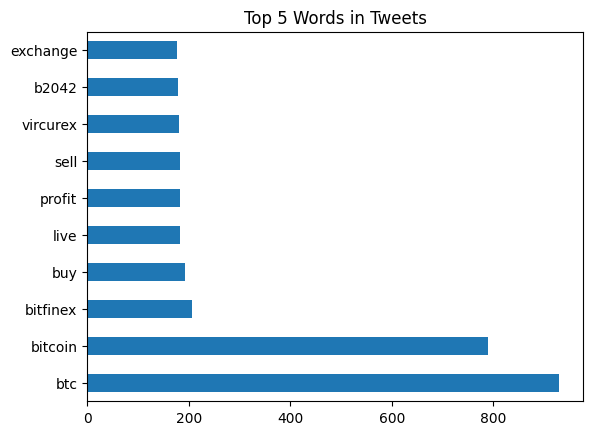

In [24]:
plot_words(tw_df.iloc[:1000],'CountVectorizer')

#detokenizing it back
detokeniser = TreebankWordDetokenizer()
tw_df['text'] = tw_df['token'].apply(lambda x: detokeniser.detokenize(x))

tw_df = tw_df[['timestamp','text']]
tw_df.head()

tw_df.to_csv('../data/3-preprocessed_tweets.csv')